In [14]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [15]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

DIRECTORY = r"C:\Users\tarun\Desktop\Seminar_Project\Face-Mask-Detection-master\dataset-3"
CATEGORIES = ["with_mask", "without_mask","mask_not_proper"]

In [16]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)
# labels.shape    

[INFO] loading images...


C:\Users\tarun\anaconda3\lib\site-packages\PIL\Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [17]:
# perform one-hot encoding on the labels
with_mask=[]
without_mask=[]
mask_not_proper=[]
for label in labels:
    if label=="with_mask":
        with_mask.append(1)
        without_mask.append(0)
        mask_not_proper.append(0)
    if label=="without_mask":
        with_mask.append(0)
        without_mask.append(1)
        mask_not_proper.append(0)
    if label=="mask_not_proper":
        with_mask.append(0)
        without_mask.append(0)
        mask_not_proper.append(1)    
        

In [18]:
labels=np.array((with_mask,without_mask,mask_not_proper))
labels=labels.T

In [19]:
labels.T.shape

(3, 8534)

In [20]:
data = np.array(data, dtype="float32")

In [21]:
# perform one-hot encoding on the labels
lb = MultiLabelBinarizer()
# labels = lb.fit_transform(labels)
# print(labels)
# labels = to_categorical(labels)

# # data = np.array(data, dtype="float32")
# # labels = np.array(labels)

In [22]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, random_state=42)
trainY.shape

(6827, 3)

In [23]:
trainX.shape

(6827, 224, 224, 3)

In [24]:
EPOCHS = 20

[INFO] compiling model...
[INFO] training head...
Epoch 1/20
213/213 [==============================] - 291s 1s/step - loss: 0.7035 - accuracy: 0.6979 - val_loss: 0.1897 - val_accuracy: 0.9256
Epoch 2/20
213/213 [==============================] - 232s 1s/step - loss: 0.2215 - accuracy: 0.9129
Epoch 3/20
213/213 [==============================] - 195s 914ms/step - loss: 0.1730 - accuracy: 0.9337
Epoch 4/20
213/213 [==============================] - 153s 715ms/step - loss: 0.1538 - accuracy: 0.9422
Epoch 5/20
213/213 [==============================] - 150s 703ms/step - loss: 0.1276 - accuracy: 0.9493
Epoch 6/20
213/213 [==============================] - 150s 705ms/step - loss: 0.1028 - accuracy: 0.9616
Epoch 7/20
213/213 [==============================] - 148s 693ms/step - loss: 0.1048 - accuracy: 0.9590
Epoch 8/20
213/213 [==============================] - 147s 690ms/step - loss: 0.1000 - accuracy: 0.9638
Epoch 9/20
213/213 [==============================] - 147s 688ms/step - loss: 0.09

ValueError: x and y must have same first dimension, but have shapes (20,) and (1,)

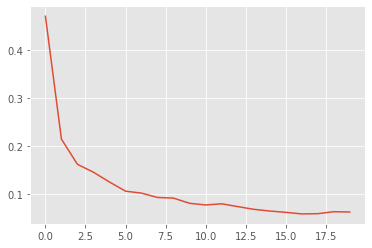

In [25]:
# (trainX, testX, trainY, testY) = train_test_split(data, labels,
# 	test_size=0.20, random_state=42)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=["with_mask","without_mask","mask_not_proper"]))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [1]:
A=[1,2,3,4]
A.pop()

4